In [1]:
import pandas as pd
import asyncio
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import contractions
from googletrans import Translator
import json
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary

from gensim.models import LdaModel


import nest_asyncio
nest_asyncio.apply()

In [2]:
# load data
df = pd.read_csv('prepro_cleaned_reviews.csv')

In [3]:
df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua padang jembatan siti nu...
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21,keras


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17664 entries, 0 to 17663
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             17664 non-null  int64 
 1   reviews            17664 non-null  object
 2   company            17664 non-null  object
 3   province           17664 non-null  object
 4   parsed_date        17664 non-null  object
 5   processed_reviews  17096 non-null  object
dtypes: int64(1), object(5)
memory usage: 828.1+ KB


In [5]:
modeling_df = df.copy()

In [6]:
# Ensure the 'processed_reviews' column is treated as string
modeling_df['processed_reviews'] = modeling_df['processed_reviews'].astype(str)

# Tokenize the processed_reviews column
modeling_df['tokenized_reviews'] = modeling_df['processed_reviews'].apply(word_tokenize)

In [7]:
# # Save the result to a new CSV file
# output_file = 'tokenized_reviews.csv'
# modeling_df.to_csv(output_file, index=False)

# print(f"Tokenized reviews saved to {output_file}")

In [8]:
modeling_df

,rating,reviews,company,province,parsed_date,processed_reviews,tokenized_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua padang jembatan siti nu...,"[letak, kawasan, kota, tua, padang, jembatan, ..."
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...,"[layan, buruk, langgan, alam, ambil, jasa, kir..."
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan,"[bagus, upaya, bangun, kantor, orang, orang, h..."
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara,"[kirim, langgan, negara]"
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus,"[layan, bagus]"
...,...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat,"[kargo, lambat]"
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret,"[lambat, cembret]"
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat]
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21,keras,[keras]


In [9]:
tokenized_reviews = modeling_df['tokenized_reviews'].tolist()  # Convert the column to a list of lists
dictionary = Dictionary(tokenized_reviews)

In [10]:
# # Save dictionary for future use
# dictionary.save('lda_dictionary.dict')

# Print dictionary information
print(f"Dictionary created with {len(dictionary)} unique tokens.")

Dictionary created with 11859 unique tokens.


In [11]:
# Word counts
word_counts = dictionary.cfs  # cfs = term frequency across the corpus
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [12]:
# Cumulative frequency
word_frequencies = [count for _, count in sorted_word_counts]
cumulative_frequencies = [sum(word_frequencies[:i]) for i in range(1, len(word_frequencies) + 1)]

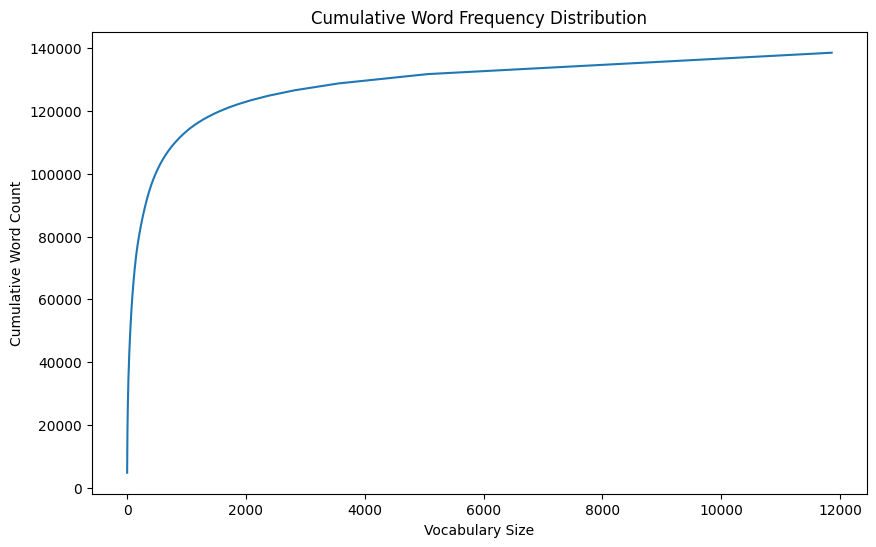

In [13]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_frequencies) + 1), cumulative_frequencies)
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Word Frequency Distribution')
plt.show()

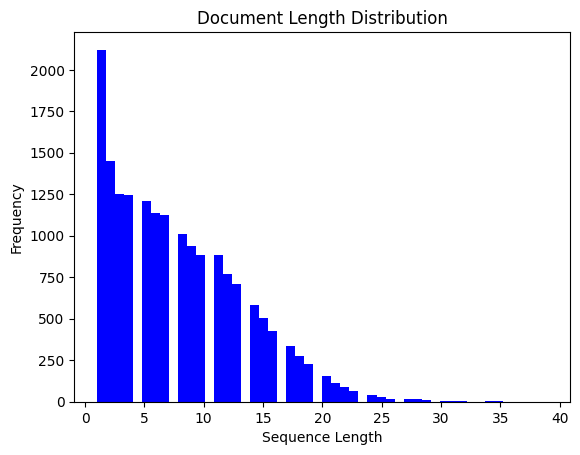

count    17664.000000
mean         7.839617
std          5.557860
min          1.000000
25%          3.000000
50%          7.000000
75%         11.000000
90%         16.000000
95%         18.000000
max         39.000000
Name: tokenized_reviews, dtype: float64


In [14]:
sequence_lengths = modeling_df['tokenized_reviews'].apply(len)

# Plot sequence length distribution
plt.hist(sequence_lengths, bins=50, color='blue')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Document Length Distribution')
plt.show()

# Print descriptive stats
print(sequence_lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]))

Average banyaknya token untuk text per review = ~8 tokens. 3 sampe 18 tokens an lah. Artinya review kebanyakan singkat padat sumpah serapah, hahaha. Kali bisa jadi EDA juga.

In [15]:
top_n = 6000  # Adjust berdasarkan "Cumulative Word Frequency Distribution"
word_coverage = sum([freq for _, freq in sorted_word_counts[:top_n]]) / sum(word_frequencies)
print(f"Word Coverage with top {top_n} words: {word_coverage:.2%}")

Word Coverage with top 6000 words: 95.77%


Nge limit pake 6000 kata udah bisa cover 95% vocabs. Artinya pakai 6000 kata pun udah nge-cover semua.

In [16]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=6000)
print(f"Filtered dictionary size: {len(dictionary)}")

Filtered dictionary size: 2264


param no_below=5:
- nge remove kata-kata yang hanya muncul di bawah 5 review.

param no_above=0.5:
- remove kata-kata yang muncul di lebih dari 50% dari review review an. Kemungkinan akan ng-remove kata "kirim"

keep_n=6000:
- Lihat di atas

In [17]:
# bikin bag of words
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

---
Coba modeling

In [18]:
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary, 
                     num_topics=4, 
                     chunksize=500, 
                     passes=30, 
                     random_state=37)

corpus: corpusnya.

id2word: dictionary di atas.

num_topics: jumlah cluster.

chunksize: Di proses berapa banyak dalam sekali proses. 500 review-an sekali proses.

passes: Berapa kali algorithm nya passes through iterasi nya. More passes katanya improve accuracy cuman lebih lama aja.

random_state: seed.

In [19]:
for i, topic in lda_model.show_topics(num_topics=4, num_words=20, formatted=False):
    print(f"Topic {i + 1}:")
    print(" ".join([word for word, _ in topic]))
    print()

Topic 1:
kerja jalan orang hilang tutup pusat cabang profesional pindah kantor malas kota mohon ngirim gudang becus pekanbaru asli kunjung hati

Topic 2:
layan buruk cepat bagus kirim customer ramah service kembali respon waktu chat butuh moga langgan ambil tunggu antri super balas

Topic 3:
antar rumah kurir kantor sortir terima paket alas orang nomor pesan telepon resi kirim nan cek mana no pas konfirmasi

Topic 4:
lambat kirim pakai cepat ekspedisi jasa ganti nama estimasi antar baik kecewa paket sesuai tahan niat expedisi hari minggu tuju

